In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
%matplotlib inline
import os
os.chdir(r'C:\test\data\santander-customer-transaction-prediction')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
y = train.pop('target')
_ = train.pop('ID_code')
_ = test.pop('ID_code')
X = train.iloc[:5000,:10]
X_test = test.iloc[:5000,:10]
y1 = y[:5000]

In [6]:
def split_cat_num(data, cat=15):
    '''对特征进行分类，得到数值特征和类别特征，对于数值特征中取值较少的特征，将其
    归为类别特征中。'''
    categorical = data.select_dtypes(include='object')
    numerical = data.select_dtypes(exclude='object')
    nunique = numerical.nunique().sort_values(ascending=True)
    n_index = nunique[nunique<cat].index
    num = numerical.columns.difference(n_index)
    category = categorical.columns
    return category, num, n_index
class TreeSplit():
    def __init__(self, bins=10, types='gini'):
        self.bins=bins
        self.types = types 
        self.mapping = {}
        self.dics={}
    def gini(self, features, y):
        result = features.copy()
        for each in features.columns:
            estimator = tree.DecisionTreeClassifier(criterion=self.types, 
                                                max_leaf_nodes=self.bins)
            X = features[each].values[:,None]
            estimator.fit(X, y)
            threshold = estimator.tree_.threshold
            thre = threshold[threshold!=-2]
            thre.sort()
            bins_ = np.zeros(self.bins+1)
            bins_[0] = -np.inf
            bins_[1:-1] = thre
            bins_[-1] = np.inf
            self.mapping[each] = bins_
            res = pd.cut(features[each], bins=bins_, 
                                  duplicates='drop')
            dic = {key:value for value,key in enumerate(res.cat.categories)}
            result[each] = res.cat.rename_categories(dic)
            self.dics[each]=dic
        return result
    def __call__(self,features, y=None):
        if y is None:
            result = features.copy()
            for each in features.columns:
                res = pd.cut(features[each],
                        bins=self.mapping[each],duplicates='drop')
                result[each] = res.cat.rename_categories(self.dics[each])
            return result
        else: 
            return self.gini(features, y)

### Logistic评分卡建模

对分箱之后的数据进行评分卡建模，主要包括，woe赋值，IV值特征选择，建模和得分计算
- 计算woe,IV值
- 通过IV值进行特征选择，我们选取IV值大于0.02的特征进行建模
- 计算建模之后的得分和基础分
- 建模

In [31]:
import sklearn.tree as tree
class ScoreCard:
    def __init__(self, cat=15,size=0.7,threshold=0.02, is_bin=False):
        self.cat = cat
        self.size=size
        self.threshold = threshold
        self.is_bin = False
        self.index = None
        
    def IV(self,features,y): # 计算woe和iV值
        m = features.shape[0]
        bads, goods = y.sum(), m-y.sum()
        ivs,woes = [],{}
        for each in features.columns:
            data = pd.concat([features[each],y],axis=1)
            data.columns=['X','Y']
            group = data.groupby('X')['Y']
            df = pd.DataFrame(group.count())
            df.rename(columns={'Y':'total'},inplace=True) # 不同类别的总数
            df['bad'] = group.sum() # 坏样本数目
            df['good'] = df['total'] - df['bad'] # 好样本数目
            df['woe'] = np.log((df['bad']+0.5)/(df['good']+0.5)) - np.log(bads/goods)
            df['mul'] = df['bad']/bads - df['good']/goods # 不同类别的权重
            iv = (df['mul'] * df['woe']).sum()
            woes[each] = df['woe'].to_dict()
            ivs.append(iv)
        self.woes = woes
        return ivs, woes
    
    def select_iv(self,data,y):
        if not self.is_bin: #是否进行过分箱，对于没有分箱的数值特征采用树分箱方法
            cat, num, n_index = split_cat_num(data,self.cat)
            treesplit = TreeSplit()
            data.loc[:,num] = treesplit(data.loc[:,num],y)
        iv,woes = self.IV(data, y)
        ser = pd.Series(iv, index=data.columns)
        index = ser[ser>=self.threshold].index
        # 对选择的特征进行woe赋值
        self.index = index
        result = data.copy()
        result = result.loc[:,index]
        for each in index:
            result[each] = result[each].map(woes[each])
        return result
    
    def calculate(self, y, P0=600, PDO=20):#就算基础分和得分
        B = PDO/np.log(2)
        theta0 = y.mean()/(1-y.mean())
        A = P0 + B*np.log(theta0)
        base = int(A - B*theta0)
        result = {}
        for feature,coef in zip(self.index,self.coef):
            temp={}
            dic = self.woes[feature]
            for key in dic:
                temp[key] = -int(B*coef*dic[key])
            result[feature] = temp
        return base, result
    
    def plot_aoc_ks(self, y, y_pred): # 绘制模型的RUC和KS曲线
        fpr,tpr,threshold = roc_curve(y, y_pred,
                                      drop_intermediate=False)
        roc_auc = auc(fpr,tpr) # 计算AUC值
        fig, (ax1, ax2) = plt.subplots(2,1)
        fig.set_figheight(10)
        fig.set_figwidth(10)
        ax1.plot(fpr,tpr,color='darkorange', lw=2, 
                       label='ROC Curve(area=%0.2f)'%roc_auc)
        ax1.plot([0,1], [0,1], color='navy',lw=2,linestyle='--')
        ax1.set_xlim(0,1)
        ax1.set_ylim(0,1.05)
        ax1.set_xlabel('False Positive Rate')
        ax1.set(xlabel='False Positve Rate',ylabel='True Positive Rate',
                         title='ROC')
        ax1.legend(loc='lower right')
        index = (tpr-fpr).argmax()
        ax2.plot(threshold, 1-tpr, label='tpr')
        ax2.plot(threshold, 1-fpr, label='fpr')
        ax2.plot(threshold, tpr-fpr, label='KS %0.2f'%(tpr-fpr)[index],
                     linestyle='--')
        ax2.vlines(threshold[index],1-fpr[index],1-tpr[index])
        ax2.set(xlabel='score')
        ax2.set_xlim(0,1)
        ax2.set_title('KS Curve')
        ax2.legend(loc='lower right', shadow=True, fontsize='medium')
        plt.show( )
        
    def __call__(self,data, y):
        train = self.select_iv(data,y)
        X,X_test,y1,y1_test = train_test_split(train,y,
                                               train_size=self.size)
        model = LogisticRegression(solver='lbfgs') # 使用逻辑回归进行建模。
        estimator = model.fit(X,y1)
        self.interpret = estimator.intercept_
        self.coef = estimator.coef_.ravel()
        y_p = estimator.predict_proba(X_test)[:,1]
        roc = roc_auc_score(y1_test,y_p)
        fpr,tpr,threshold = roc_curve(y1_test, y_p,
                                      drop_intermediate=False)
        ks = (tpr-fpr).max()
        self.plot_aoc_ks(y1_test,y_p)
        return roc, ks

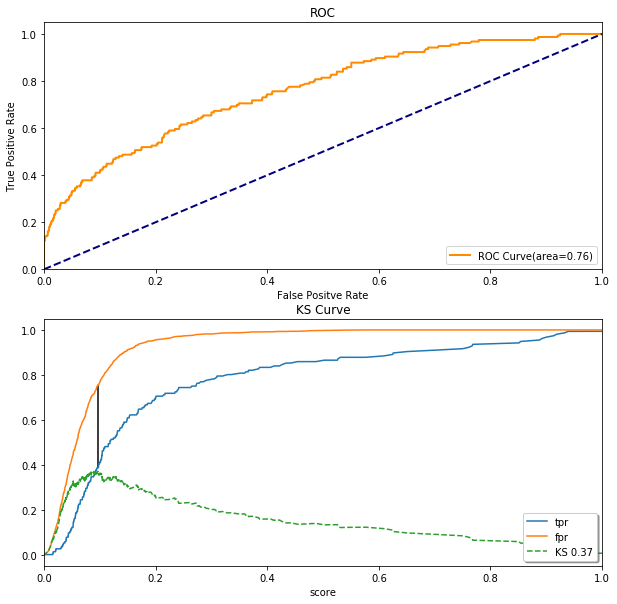

(0.7584897741147741, 0.3705929487179488)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,auc
sc = ScoreCard()
sc(X,y1)

In [33]:
score = sc.calculate(y1)
score[0],score[1]['var_0']

(532,
 {0: -7,
  1: -106,
  2: -60,
  3: -12,
  4: -106,
  5: 13,
  6: -106,
  7: 1,
  8: -106,
  9: -14})

### 模型调参和模型结果可视化
对模型超参数进行调参，并对结果进行可视化
- 模型调参的方法分为GridSearch和坐标上升法两种方式，后者应对一次调节参数数目过多的情况。
- 计算模型的auc和ks值
- 可视化模型的auc和ks值

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold

In [34]:
class Model:
    
    def __init__(self, estimator, params=None, cv=5, score=None,
                 imbalance=False,grid=False):
        self.estimator = estimator # 模型
        self.params = params# 调节参数,字典
        self.grid=grid # 是否使用网格收索
        
        if params is None: # 如果params非空,则进行调参。
            self.SEARCH = False # 是否进行调参
        else: self.SEARCH = True
            
        if imbalance: self.cv = StratifiedKFold(cv)
        else: self.cv=cv # 是否为类别不平衡
            
        self.score = score # 评分函数
        self.res = {} 
        self.temp = self.estimator.get_params()
    
    def isequal(self,res): # 辅助函数。
        if not(isinstance(res,dict) and isinstance(self.temp,dict)):
            return False
        keys = set(res.keys()).union(self.temp.keys())
        for key in keys:
            if res.get(key,'x') != self.temp.get(key, 'x'):
                return False
        return True
    
    def search(self, X, y): #进行调参
        if self.grid: # 采用网格搜索
            grid = GridSearchCV(self.estimator,param_grid=self.params,
                               scoring=self.score, cv=self.cv, iid=True,
                               n_jobs=-1)
            grid.fit(X,y)
            self.temp = grid.best_params_
            self.estimator = grid.best_estimator_
            # 保存搜索过程中的结果
            self.res['mean'] = grid.cv_results_['mean_test_score']
            self.res['std'] = grid.cv_results_['std_test_score']
            return grid.best_score_
        else: # 采用梯度上升算法进行搜索
            i,res, means,stds= 0,{ },[ ],[ ]
            while i<=20 and not(self.isequal(res)):
                res = self.temp
                stepmean, stepstd = [], []
                for each in self.params:
                    grid = GridSearchCV(self.estimator,
                         param_grid={each:self.params[each]},
                         scoring=self.score, cv=self.cv, iid=True,
                         n_jobs=-1)
                    grid.fit(X, y)
                    mean = grid.cv_results_['mean_test_score'].tolist()
                    std = grid.cv_results_['std_test_score'].tolist()
                    stepmean.extend(mean)
                    stepstd.extend(std)
                    self.temp = grid.best_params_
                    self.estimator = grid.best_estimator_
                means.append(stepmean)
                stds.append(stepstd)
                i += 1
            self.res['mean'] = means
            self.res['std'] = stds
            return grid.best_score_
    
    def is_search(self, X, y): # 对模型进行调参
        if self.SEARCH:
            score = self.search(X, y)
        else:
            self.estimator.fit(X,y)
        
    def get_fpr_tpr(self, X, y):
        y_pred = self.estimator.predict_proba(X)[:,1]
        fpr,tpr,threshold = roc_curve(y, y_pred,
                                      drop_intermediate=False) 
        return fpr, tpr, threshold
    
    def get_auc_ks(self, X, y):
        fpr, tpr, threshold = self.get_fpr_tpr(X, y)
        roc_auc = auc(fpr,tpr)
        ks = (tpr-fpr).max()
        return roc_auc, ks
    
    def plot_aoc_ks(self, X, y):
        fpr, tpr, threshold = self.get_fpr_tpr(X, y)
        roc_auc = auc(fpr,tpr) # 计算AUC值
        fig, (ax1, ax2) = plt.subplots(2,1)
        fig.set_figheight(10)
        fig.set_figwidth(10)
        ax1.plot(fpr,tpr,color='darkorange', lw=2, 
                       label='ROC Curve(area=%0.2f)'%roc_auc)
        ax1.plot([0,1], [0,1], color='navy',lw=2,linestyle='--')
        ax1.set_xlim(0,1)
        ax1.set_ylim(0,1.05)
        ax1.set_xlabel('False Positive Rate')
        ax1.set(xlabel='False Positve Rate',ylabel='True Positive Rate',
                         title='ROC')
        ax1.legend(loc='lower right')
        index = (tpr-fpr).argmax()
        ax2.plot(threshold, 1-tpr, label='tpr')
        ax2.plot(threshold, 1-fpr, label='fpr')
        ax2.plot(threshold, tpr-fpr, label='KS %0.2f'%(tpr-fpr)[index],
                     linestyle='--')
        ax2.vlines(threshold[index],1-fpr[index],1-tpr[index])
        ax2.set(xlabel='score')
        ax2.set_xlim(0,1)
        ax2.set_title('KS Curve')
        ax2.legend(loc='lower right', shadow=True, fontsize='medium')
        plt.show( )
        
    def __call__(self, X, y=None):
        if y is None:
            return self.estimator.predict_proba(X)[:,1]
        else:
            _ = self.is_search(X,y)
            return self.get_auc_ks(X, y)

In [41]:
import lightgbm as lgb

In [43]:
from sklearn.model_selection import GridSearchCV
est = lgb.LGBMClassifier()
param={'n_estimators':range(50,500,50),
       'max_depth': range(3,6,1),
       'num_leaves':range(5, 20, 1),}
mod = Model(est,param)
X = train.iloc[:5000,:10]
mod(X,y1)

(0.7522270820640895, 0.376160405417887)

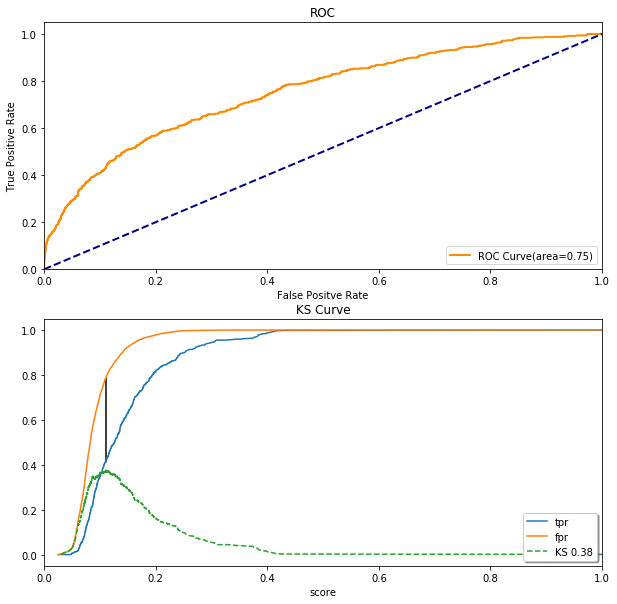

In [45]:
mod.plot_aoc_ks(X,y1)

In [47]:
mod(X_test)

array([0.19717099, 0.0963388 , 0.07728273, ..., 0.10488917, 0.08290926,
       0.05377218])

模型选择函数，通过不同的模型对数据进行建模，并可视化结果，可以最终选取结果较好的模型，来进行后续的调参等。

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from xgboost import XGBClassifier
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
def models_eval(X,y, scoring='roc_auc'):
    clfs = []
    seed, n_folds = 42, 7
    clfs.append(("LogReg", Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression())])))
    clfs.append(("XGBClassifier", XGBClassifier()))
    clfs.append(("LGBMClassifier", LGBMClassifier()))
    clfs.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
    clfs.append(("RandomForestClassifier", 
                 ensemble.RandomForestClassifier(n_estimators=100)))
    clfs.append(("GradientBoostingClassifier", 
                 ensemble.GradientBoostingClassifier(n_estimators=100)))
    clfs.append(("RidgeClassifier", Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))
    clfs.append(("BaggingClassifier", Pipeline([("Scaler", StandardScaler()),
                ("BaggingClassifier", ensemble.BaggingClassifier())])))
    clfs.append(("ExtraTreesClassifier",ensemble.ExtraTreesClassifier()))

    results, names  = [], [] 
    for name, model  in clfs:
        kfold = KFold(n_splits=n_folds, shuffle=False, random_state=seed)
        cv_results = cross_val_score(model, X.values, y, 
                                 cv= kfold, scoring=scoring, n_jobs=-1)    
        names.append(name)
        results.append(cv_results)    
        msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  
                               cv_results.std())
        print(msg)
    fig = plt.figure(figsize=(15,6))
    fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
    ax = fig.add_subplot(111)
    sns.boxplot(x=names, y=results)
    ax.set_xticklabels(names)
    ax.set_xlabel("Algorithmn", fontsize=20) 
    ax.set_ylabel("Score of Models", fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    plt.show()

LogReg: 0.597073 (+/- 0.025384)
XGBClassifier: 0.610960 (+/- 0.037356)
LGBMClassifier: 0.572628 (+/- 0.032162)
DecisionTreeClassifier: 0.520529 (+/- 0.011994)
RandomForestClassifier: 0.589828 (+/- 0.024637)
GradientBoostingClassifier: 0.605507 (+/- 0.034403)
RidgeClassifier: 0.597264 (+/- 0.025173)
BaggingClassifier: 0.565453 (+/- 0.028257)
ExtraTreesClassifier: 0.544674 (+/- 0.028696)


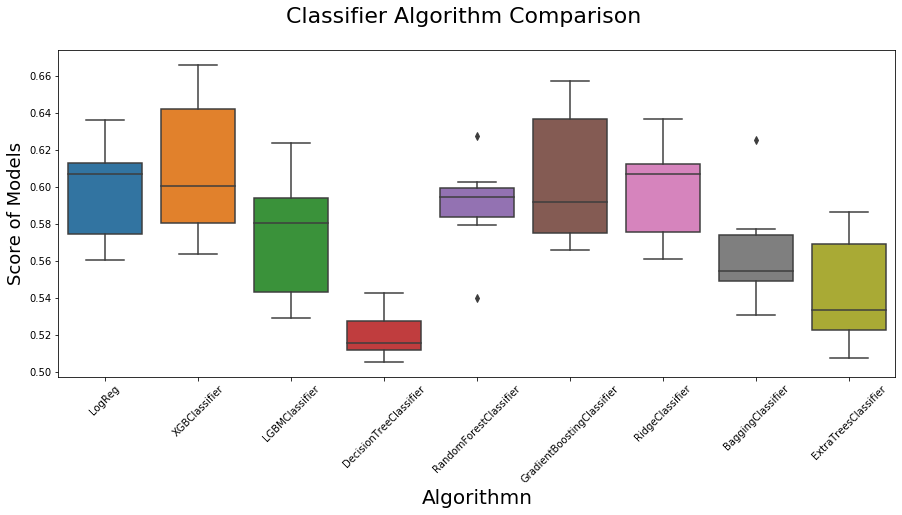

In [51]:
models_eval(X,y1)

In [ ]:
accuracies = {}

lr = LogisticRegression()
lr.fit(x_train.T,y_train.T)
acc = lr.score(x_test.T,y_test.T)*100
accuracies['Logistic Regression'] = acc
# K Neighbors Classifier
# Support Vector Machine
#Naive Bayes Classifier
#Decision Tree Classifier
# Random Forest Classification

# 模型比较
from itertools import cycle
colors = cycle(["purple", "green", "orange", "magenta","#CFC60E","#0FBBAE"])
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), 
            y=list(accuracies.values()),
            palette=colors)
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score
def plot_precision_recall(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true,y_pred)
    AP = average_precision_score(y_true,y_pred)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    return AP
def printing_Kfold_scores(x_train,y_train,params):
    fold = KFold(len(y_train),5,shuffle=False) 
    results_table = pd.DataFrame(index = range(len(params),2), 
                    columns = ['parameter','Mean recall score'])
    results_table['parameter'] = params
    j = 0
    for param in params:
        recall_accs = []
        for iteration, indices in enumerate(fold,start=1):
            lr = LogisticRegression(C = param, penalty = 'l1')
            lr.fit(x_train.iloc[indices[0],:],
                   y_train.iloc[indices[0],:].values.ravel())
            y_pred_undersample = lr.predict(
                x_train.iloc[indices[1],:].values)
            recall_acc = recall_score(
                y_train.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': recall score = ', recall_acc)
        results_table.ix[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1

    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']    
    return best_c
#P-R
from itertools import cycle
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue',
                'teal', 'red', 'yellow', 'green', 'blue','black'])

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# classifier list for the normal training set
clf_list = [DecisionTreeClassifier(max_depth = 3, 
                                   class_weight = "balanced"), 
            RandomForestClassifier(n_estimators = 100, 
                                   class_weight = "balanced"), 
            AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3,
                                    class_weight = "balanced"),
                               n_estimators = 100), 
            GradientBoostingClassifier(), 
            XGBClassifier()
           ]

# use Kfold to evaluate the normal training set
kf = KFold(n_splits=5,random_state=42,shuffle=True)

mdl = []
fold = []
scr = []

for i,(train_index, test_index) in enumerate(kf.split(df_train)):
    training = df.iloc[train_index,:]
    valid = df.iloc[test_index,:]
    for clf in clf_list:
        model = clf.__class__.__name__
        feats = training[features] #defined above
        label = training['def_pay']
        valid_feats = valid[features]
        valid_label = valid['def_pay']
        clf.fit(feats,label) 
        pred = clf.predict(valid_feats)
        score = f1_score(y_true = valid_label, y_pred = pred)
        fold.append(i+1)
        scr.append(score)
        mdl.append(model)
        print(model)
    
performance = pd.DataFrame({'Model': mdl, 'Score':scr,'Fold':fold})